## drive/colab

In [38]:
is_colab = False

In [39]:
# load drive
if is_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  %cd /content/
  print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content


## imports and constants

In [ ]:
# imports
import os
import sys
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import keras
!pip install rotation-forest
import warnings
import datetime
from scipy.stats import friedmanchisquare
!pip install scikit-posthocs
import scikit_posthocs as sp
import xgboost as xgb
import matplotlib.pyplot as plt

# constants
MAIN_WD = os.getcwd()
CLASS0 = 0
CLASS1 = 1
RESULTS_OUTPUT_DIR = 'drive/My Drive/Colab Notebooks/ML_ass4/results' if is_colab else os.getcwdb()
RESULTS_CSV_COLUMNS = ['dataset name','algorithm name','cross validation', 'hyper-parameters', 'accuracy', 'TPR', 'FPR','precision','AUC', 'PR-Curve', 'train time', 'inference time']
ALGORITHMS = ['rotation_forest', 'gcforest', 'ogboost', 'grboost']

## Drive Imports

### import data

In [41]:
def uniform_data(raw_dataset):
  """Converts the data into a uniform format"""
  
  x_cols = raw_dataset.columns[:-1]
  y_cols = raw_dataset.columns[-1]

  lb = preprocessing.LabelEncoder()
  X = raw_dataset[x_cols]
  for col in X.columns:
    if X[col].dtype != int and X[col].dtype != float:
      lb.fit(X[col].astype(str))
      X[col] = lb.transform(X[col].astype(str))
      
    if X[col].dtype == float:
      X[col] = X[col].fillna(X[col].mean())
    else:
      X[col] = X[col].fillna(X[col].mode())
  
  y = raw_dataset[y_cols]
  # the most common class will be encoded as 0, the rest will all be 1
  lb.fit(y.astype(str))
  y = lb.transform(y.astype(str))
  y = pd.Series(y)
  class0 = y.mode().iloc[0]
  y[y != class0] = (CLASS0 if class0 == 1 else CLASS1)
  y[y == class0] = (CLASS1 if class0 == 1 else CLASS0)
  y = y.astype(int)

  return X,y

In [ ]:
# get algorithm zips from drive
if is_colab:
  %cd -q /content
  data_dir = 'classification_datasets'
  datafile_path = 'drive/My Drive/Colab Notebooks/ML_ass4/{}.zip'.format(data_dir)

  print("found data file" if os.path.exists(datafile_path) else "data file not found")
  if not os.path.exists(data_dir):
      zip_path = datafile_path
      print("importing data from drive")
      !cp "{zip_path}" .
      !unzip -q "{data_dir}".zip
      !rm "{data_dir}".zip

# load all datasets and convert them to a uniform format
datasets = []
for file in os.listdir(data_dir):
  raw_dataset = pd.read_csv(os.path.join(data_dir, file))
  X, y = uniform_data(raw_dataset)

  if(X.shape[0] < 20):
    print('skipped {}'.format(file))
    continue

  datasets.append( (X, y, file) )
print('loaded {} datasets'.format(len(datasets)))


### import code for algorithms

In [ ]:
if is_colab:
  # gc forest
  %cd -q /content
  data_dir = 'gcforest'
  datafile_path = 'drive/My Drive/Colab Notebooks/ML_ass4/{}.zip'.format(data_dir)

  print("found data file {}".format(data_dir) if os.path.exists(datafile_path) else "data file not found")
  if not os.path.exists(data_dir):
      zip_path = datafile_path
      print("importing data from drive")
      !cp "{zip_path}" .
      !unzip -q "{data_dir}".zip
      !rm "{data_dir}".zip

  # ogboost and grboost
  data_dir = 'GreedyBoost'
  datafile_path = 'drive/My Drive/Colab Notebooks/ML_ass4/{}.zip'.format(data_dir)

  print("found data file{}".format(data_dir) if os.path.exists(datafile_path) else "data file not found")
  if not os.path.exists(data_dir):
      zip_path = datafile_path
      print("importing data from drive")
      !cp "{zip_path}" .
      !unzip -q "{data_dir}".zip
      !rm "{data_dir}".zip

### algorithm import statements

In [44]:
from rotation_forest import RotationTreeClassifier
from gcforest.gcforest import GCForest
import subprocess

## generic functions

In [45]:
def get_toy_config():
    """A basic configuration for gcforest"""
    config = {}
    ca_config = {}
    ca_config["random_state"] = 0
    ca_config["max_layers"] = 100
    ca_config["early_stopping_rounds"] = 3
    ca_config["n_classes"] = 2
    ca_config["estimators"] = []
    ca_config["estimators"].append({"n_folds": 1, "type": "RandomForestClassifier", "n_estimators": 10, "max_depth": None, "n_jobs": -1})
    config["cascade"] = ca_config
    return config

def train_and_predict(algo, X_train, y_train,X_test, y_test, hyper_params):
    """
    Parameters:
    algo (str): one of [rotation_forest, gcforest, ogboost, grboost]
    """
    if algo == 'rotation_forest':
      with warnings.catch_warnings():
        # ignore all caught warnings
        warnings.filterwarnings("ignore")
        # execute code that will generate warnings
        algo = RotationTreeClassifier()
        start_train = datetime.datetime.now()
        algo.fit(X_train.values, y_train.values)
        end_train = datetime.datetime.now()
        y_pred = algo.predict(X_test.values)
        end_predict = datetime.datetime.now()
    elif algo == 'gcforest':
      algo = GCForest(get_toy_config())
      start_train = datetime.datetime.now()
      algo.fit_transform(X_train.values, y_train.values)
      end_train = datetime.datetime.now()
      y_pred = algo.predict(X_test.values)
      end_predict = datetime.datetime.now()
    elif algo == 'ogboost' or algo == 'grboost':
      classes = [-1.0,1.0]
      y_train = y_train.astype(float, copy=True)
      y_train[y_train == CLASS0] = -1.0
      y_train[y_train == CLASS1] = 1.0

      %cd -q "{MAIN_CWD}"
      # write all data to file for reading by package
      tmp = X_train.append(X_test)
      tmp['class'] = y_train.append(y_test)
      test_size = len(y_test)/(len(y_train)+len(y_test))

      tmp.to_csv('GreedyBoost/data/car.csv', index=False, float_format='%.3f')

      %cd -q "{MAIN_CWD}"
      start_train = datetime.datetime.now()
      command_line = "python2 ./main.py car ogboost random_stump 100 {}".format(test_size) if algo=='ogboost' else "python2 ./modifications/main_dynamic.py car ozaboost random_stump 100 {}".format(test_size)
      p = subprocess.Popen(command_line, stdout=subprocess.PIPE, shell=True)
      output, err = p.communicate()  
      p_status = p.wait()
      output = output.decode("utf-8") 
      end_train = datetime.datetime.now()

      %cd -q "{MAIN_CWD}"
      output = output.replace('[', '').replace(' ', '').replace(']', '').replace('\n', '')
      output = output.split(',')
      y_pred = [float(prediction) for prediction in output]
      y_pred = np.array(y_pred, dtype=float)
      y_pred[y_pred == -1.0] = CLASS0
      y_pred[y_pred == 1.0] = CLASS1
      y_pred = y_pred.astype(int)
      end_predict = datetime.datetime.now()
    
    elif algo == 'xgboost':
      algo = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
      start_train = datetime.datetime.now()
      algo.fit(X_train.values, y_train.values)
      end_train = datetime.datetime.now()
      y_pred = algo.predict(X_test.values)
      end_predict = datetime.datetime.now()

    train_time = (end_train - start_train).total_seconds()
    inference_time = (end_predict - end_train).total_seconds()
    return y_pred, train_time, inference_time

def evaluate(y_test, y_pred):
  """Evaluate on a test set and return a dictionary of metrics"""
  evaluations = {}
  evaluations['accuracy'] = metrics.accuracy_score(y_test, y_pred)
  evaluations['precision'] = metrics.average_precision_score(y_test, y_pred)
  if len(np.unique(y_test)) == 2:
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)
    evaluations['PR-Curve'] = metrics.auc(recall, precision)
    evaluations['AUC'] = metrics.roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    evaluations['TPR'] = tp/np.count_nonzero(y_test == 1)
    evaluations['FPR'] = fp/np.count_nonzero(y_test == 0)
  else:
    evaluations['AUC'] = ''
    evaluations['TPR'] = ''
    evaluations['FPR'] = ''

  return evaluations

def kfold_evaluation(algo, datasets, folds=10, hyper_params={}, results_to_disk=False, k_fold_strategy = 'stratified'):
  """Evaluate the algorithm on the different datasets using K-fold validation"""
  results = pd.DataFrame(columns=RESULTS_CSV_COLUMNS)
  kf = StratifiedKFold(n_splits=folds, shuffle=True) if k_fold_strategy == 'stratified' else KFold(n_splits=folds, shuffle=True)
  dataset_num = 0
  for X,y,name in datasets:
    dataset_num += 1

    current_k = 1
    for train_index, test_index in kf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      y_pred, train_time, inference_time = train_and_predict(algo, X_train, y_train, X_test, y_test, hyper_params)

      evaluations = evaluate(y_test=y_test, y_pred=y_pred)
      evaluations['dataset name'] = name
      evaluations['algorithm name'] = algo
      evaluations['cross validation'] = current_k
      evaluations['hyper-parameters'] = "\"" + str(hyper_params) + "\""
      evaluations['train time'] = train_time
      evaluations['inference time'] = inference_time
      results = results.append(evaluations, ignore_index=True)

      print('dataset {} ({}) ; fold {} ; accuarcy {:f} ; time(s) {:f}'.format(name, dataset_num, current_k, evaluations['accuracy'], train_time+inference_time))

      current_k += 1
  
  if results_to_disk:
    results.to_csv(path_or_buf=os.path.join(RESULTS_OUTPUT_DIR,algo+'_results.csv'))
  return results


## main evaluations

In [ ]:
results_rotation_forest = kfold_evaluation('rotation_forest', datasets, 10, {}, True)

In [9]:
results_gcforest = kfold_evaluation('gcforest', datasets, 10, {}, True)

In [10]:
results_ogboost = kfold_evaluation('ogboost', datasets, 10, {}, True)

In [11]:
results_grboost = kfold_evaluation('grboost', datasets, 10, {}, True)

In [35]:
# create unified table of all results
tmp = pd.DataFrame(columns=RESULTS_CSV_COLUMNS)
for algo in ALGORITHMS:
  tmp.append(pd.read_csv(os.path.join(RESULTS_OUTPUT_DIR,algo+'_results.csv')), ignore_index=True)
tmp.to_csv(os.path.join(RESULTS_OUTPUT_DIR,'all'+'_results.csv'))

## Test Statistical Significance

### Friedman test

In [ ]:
# load the sets of results
def clean_column_names(df):
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
  return df

res_rotation_forest = clean_column_names(pd.read_csv(os.path.join(RESULTS_OUTPUT_DIR,'rotation_forest'+'_results.csv'), index_col=0))
res_gcforest = clean_column_names(pd.read_csv(os.path.join(RESULTS_OUTPUT_DIR,'gcforest'+'_results.csv'), index_col=0))
res_ogboost = clean_column_names(pd.read_csv(os.path.join(RESULTS_OUTPUT_DIR,'ogboost'+'_results.csv'), index_col=0))
res_grboost = clean_column_names(pd.read_csv(os.path.join(RESULTS_OUTPUT_DIR,'grboost'+'_results.csv'), index_col=0))

In [14]:
# convert to averages of each 10-fold cross validation
def group_by_dataset(df):
  return df.groupby(['dataset_name','algorithm_name'], as_index=False).mean()

res_rotation_forest = group_by_dataset(res_rotation_forest)
res_gcforest = group_by_dataset(res_gcforest)
res_ogboost = group_by_dataset(res_ogboost)
res_grboost = group_by_dataset(res_grboost)

In [15]:
# unify data
def get_measure_on_dataset(results, dataset_name, measure_name):
  return results.loc[results['dataset_name'] == dataset_name, measure_name].iloc[0]

measure = 'accuracy'
acc_measures = pd.DataFrame(columns=['dataset','rotation_forest', 'gcforest', 'ogboost', 'grboost'])
for name in res_rotation_forest['dataset_name']:
  acc_measures = acc_measures.append({'dataset': name,'rotation_forest': get_measure_on_dataset(res_rotation_forest, name, measure), 
                                      'gcforest': get_measure_on_dataset(res_gcforest, name, measure), 'ogboost': get_measure_on_dataset(res_ogboost, name, measure), 
                                      'grboost': get_measure_on_dataset(res_grboost, name, measure)}, ignore_index=True)
acc_measures_no_names = acc_measures.drop('dataset', axis=1)

In [16]:
# perform Friedman test
measure_lists = [acc_measures_no_names['rotation_forest'].to_numpy(), acc_measures_no_names['gcforest'].to_numpy(), acc_measures_no_names['ogboost'].to_numpy(), acc_measures_no_names['grboost'].to_numpy()]
statistic, pvalue = friedmanchisquare(measure_lists[0], measure_lists[1], measure_lists[2], measure_lists[3])

significant = pvalue < 0.05
print('the p value is {}, which is {} than 0.05, so we {} the null hypothesis, and {}.'.
      format(pvalue, 'less' if significant else 'more', 'reject' if significant else 'accept', 'continue' if significant else 'stop'))

the p value is 1.5302422844898138e-59, which is less than 0.05, so we reject the null hypothesis, and continue.


### Post-Hoc test

In [18]:
## now perform a post-hoc test to determine pairwise relations

alpha = 0.05
posthoc_pvalues = sp.posthoc_nemenyi_friedman(acc_measures_no_names, melted=False)
posthoc_pvalues

,rotation_forest,gcforest,ogboost,grboost
rotation_forest,1.000,0.001,0.001000,0.001000
gcforest,0.001,1.000,0.001000,0.001000
ogboost,0.001,0.001,1.000000,0.440052
grboost,0.001,0.001,0.440052,1.000000


In [19]:
# pairwise statistic must be larger than the critical
posthoc_pvalues.applymap(lambda pval: 'different' if pval < alpha  else 'same')

,rotation_forest,gcforest,ogboost,grboost
rotation_forest,same,different,different,different
gcforest,different,same,different,different
ogboost,different,different,same,same
grboost,different,different,same,same


In [20]:
# determine ordering

acc_means = acc_measures_no_names.mean()
acc_means.sort_values(ascending=False, inplace=True)
print('Comparison of average {} (across all datasets) between algorithms:\n'.format(measure))
print(acc_means)
print('\nogboost and grboost are not significantly different')

Comparison of average accuracy (across all datasets) between algorithms:

gcforest           0.835711
rotation_forest    0.805225
ogboost            0.588100
grboost            0.503752
dtype: float64

ogboost and grboost are not significantly different


## Meta-Learning

In [29]:
if is_colab:
  # get meta features dataset
  meta_features_url = 'drive/My Drive/Colab Notebooks/ML_ass4/ClassificationAllMetaFeatures.csv'
  !cp "{meta_features_url}" .
else:
  meta_features_url = MAIN_CWD

In [ ]:
## add target attribute to meta features 

meta_features = pd.read_csv(filepath_or_buffer='ClassificationAllMetaFeatures.csv')
# clean dataset names
acc_measures_short_names = acc_measures.copy()
acc_measures_short_names['dataset'] = acc_measures_short_names['dataset'].apply(lambda name: name.replace('.csv', ''))

# sort and set the dataset names as the index
acc_measures_short_names.sort_values('dataset', axis=0, ascending=True, inplace=True)
acc_measures_short_names.set_index(keys='dataset', drop=True, inplace=True)
meta_features.sort_values('dataset', axis=0, ascending=True, inplace=True)

# because the meta features dataset contains corrupt dataset names (missing end), we try to correct it
meta_features.set_index(keys='dataset', drop=True, inplace=True)
meta_features.set_index(keys=acc_measures_short_names.index, drop=True, inplace=True)

# find best algo for each datset
algorithms = acc_measures_short_names.columns.to_numpy()
meta_features['algo'] = ''
for index, row in acc_measures_short_names.iterrows():
  best = np.argmax(row.to_numpy())
  best = algorithms[best]
  meta_features.at[index, 'algo'] = best

print(meta_features)

In [ ]:
# encode data

encoder = preprocessing.LabelEncoder()
encoder.fit(meta_features['algo'])

In [ ]:
# train using leave-one-out method

encoded_meta_features = meta_features.copy()
encoded_meta_features['algo'] = encoder.transform(encoded_meta_features['algo'])
print(encoded_meta_features)

target_name = encoded_meta_features.columns[-1]
print(target_name)
results_metalearning = kfold_evaluation('xgboost', 
                                        datasets=[(encoded_meta_features.drop(target_name, axis=1, inplace=False), encoded_meta_features[target_name], 'meta_features')],
                                        folds=encoded_meta_features.shape[0], hyper_params={}, results_to_disk=True, k_fold_strategy='regular')

weight feature importance
{'FeaturesLabels.PearsonCorrelation.StandardDeviation': 40, 'f7': 8, 'missing values': 3, 'f62': 19, 'f1': 7, 'Labels.Mean.NonAggregated': 93, 'f110': 68, 'f22': 16, 'FeaturesLabels.PearsonCorrelation.Mean': 32, 'Features.Kurtosis.StandardDeviation': 73, 'attributes total': 50, 'f54': 13, 'f34': 2, 'Features.Mean.StandardDeviation': 7, 'f65': 2, 'Labels.Kurtosis.NonAggregated': 7, 'instances_with_missing_val': 5, 'f21': 1, 'FeaturesLabels.SpearmanCorrelation.Mean': 4, 'f63': 26, 'f25': 19, 'Features.PearsonCorrelation.Mean': 83, 'f55': 4, 'Features.Skew.Mean': 36, 'f122': 14, 'f82': 11, 'f97': 4, 'Features.Skew.StandardDeviation': 22, 'Features.SpearmanCorrelation.Mean': 27, 'f9': 3, 'f117': 8, 'f115': 34, 'f107': 24, 'Features.Mean.Mean': 6, 'Labels.Skew.NonAggregated': 25, 'f2': 1, 'Features.SpearmanCorrelation.StandardDeviation': 15, 'f106': 1, 'f33': 40, 'f41': 1, 'f61': 11, 'f45': 2, 'nonzero_vals_cnt': 17, 'f56': 7, 'f113': 12, 'f89': 1, 'f39': 6, 'f52':

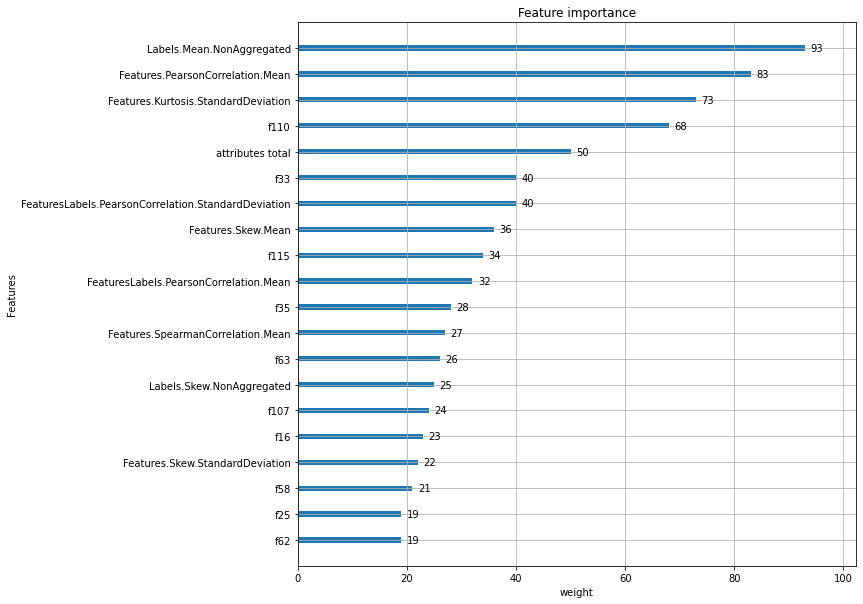

gain feature importance
{'FeaturesLabels.PearsonCorrelation.StandardDeviation': 1.5056380073625004, 'f7': 3.007021321, 'missing values': 3.5360132866666665, 'f62': 1.9153797568999997, 'f1': 0.6876961205714285, 'Labels.Mean.NonAggregated': 0.8701515308978494, 'f110': 0.9614948542088235, 'f22': 1.1857425040874998, 'FeaturesLabels.PearsonCorrelation.Mean': 1.5252232471531249, 'Features.Kurtosis.StandardDeviation': 1.8812827618109595, 'attributes total': 0.8859106213696003, 'f54': 1.3725765079769228, 'f34': 2.04648304, 'Features.Mean.StandardDeviation': 1.336828317814286, 'f65': 0.3052462635, 'Labels.Kurtosis.NonAggregated': 0.7115777320857145, 'instances_with_missing_val': 1.5417971352, 'f21': 0.459772348, 'FeaturesLabels.SpearmanCorrelation.Mean': 2.98715937, 'f63': 1.100518511007692, 'f25': 0.7596907975947369, 'Features.PearsonCorrelation.Mean': 0.7648229538939761, 'f55': 1.207649656275, 'Features.Skew.Mean': 0.8303674131111115, 'f122': 0.24334898477857145, 'f82': 1.695917741181818, 'f9

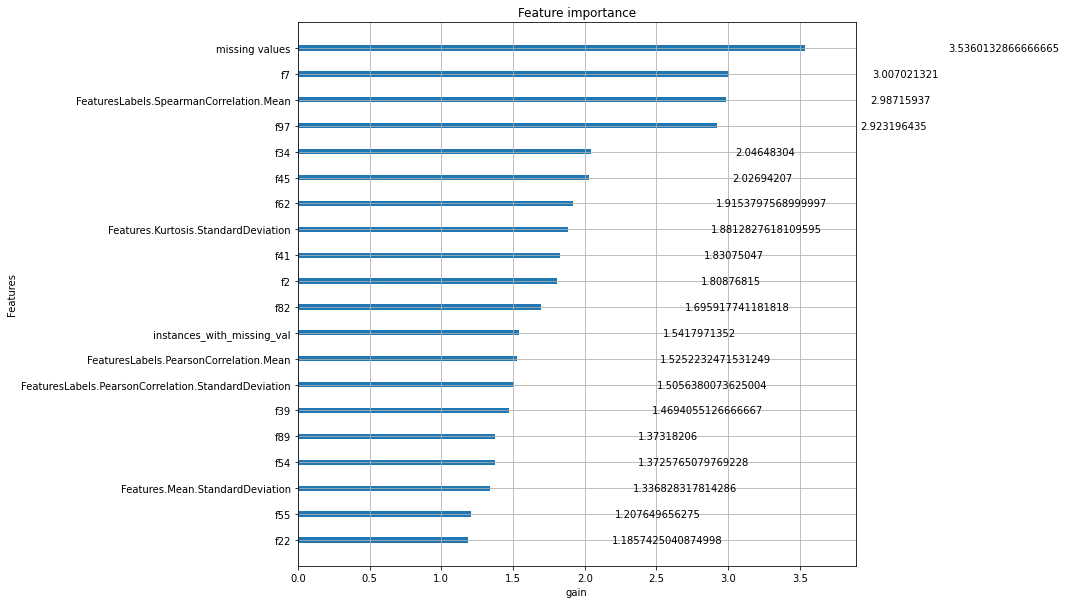

cover feature importance
{'FeaturesLabels.PearsonCorrelation.StandardDeviation': 36.22841591775001, 'f7': 35.530531485, 'missing values': 56.04355366666667, 'f62': 8.802676058421053, 'f1': 6.522019861428573, 'Labels.Mean.NonAggregated': 19.14814786903226, 'f110': 9.997347346029409, 'f22': 29.768373324375, 'FeaturesLabels.PearsonCorrelation.Mean': 9.405544210937498, 'Features.Kurtosis.StandardDeviation': 23.31492040712328, 'attributes total': 10.596108597399997, 'f54': 12.17853553923077, 'f34': 42.8086281, 'Features.Mean.StandardDeviation': 15.813264741428569, 'f65': 4.85872054, 'Labels.Kurtosis.NonAggregated': 15.153251554285713, 'instances_with_missing_val': 32.915504076000005, 'f21': 7.21704483, 'FeaturesLabels.SpearmanCorrelation.Mean': 18.6009202, 'f63': 16.466574592307694, 'f25': 8.95574142263158, 'Features.PearsonCorrelation.Mean': 16.82020382240964, 'f55': 11.6849073325, 'Features.Skew.Mean': 6.2996790491666665, 'f122': 13.943509317142855, 'f82': 10.570881435454545, 'f97': 23.62

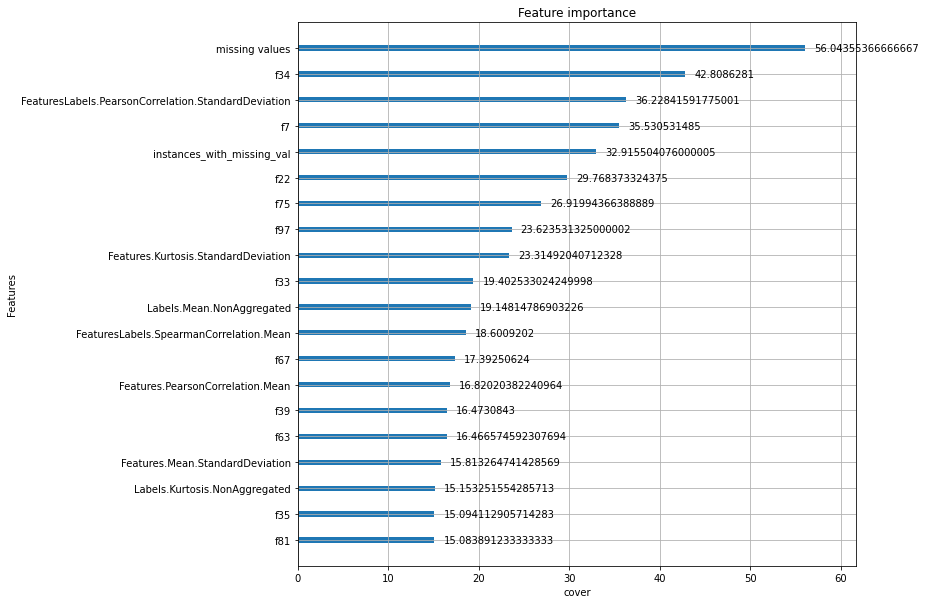

In [27]:
# train using all data (with small holdout set of 5 samples) to determine feature importance

# X_train, X_test, y_train, y_test = train_test_split(encoded_meta_features.drop(target_name, axis=1, inplace=False), encoded_meta_features[target_name], test_size=5)
X_train, y_train = encoded_meta_features.drop(target_name, axis=1, inplace=False), encoded_meta_features[target_name]
model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
model.fit(X_train, y_train)

for feature in ['weight', 'gain', 'cover']:
  print(feature + ' feature importance')
  fig, ax = plt.subplots(figsize=(10, 10))
  xgb.plot_importance(model.get_booster(), importance_type=feature, max_num_features=20, xlabel=feature, ax=ax)
  plt.show()

SHAP:


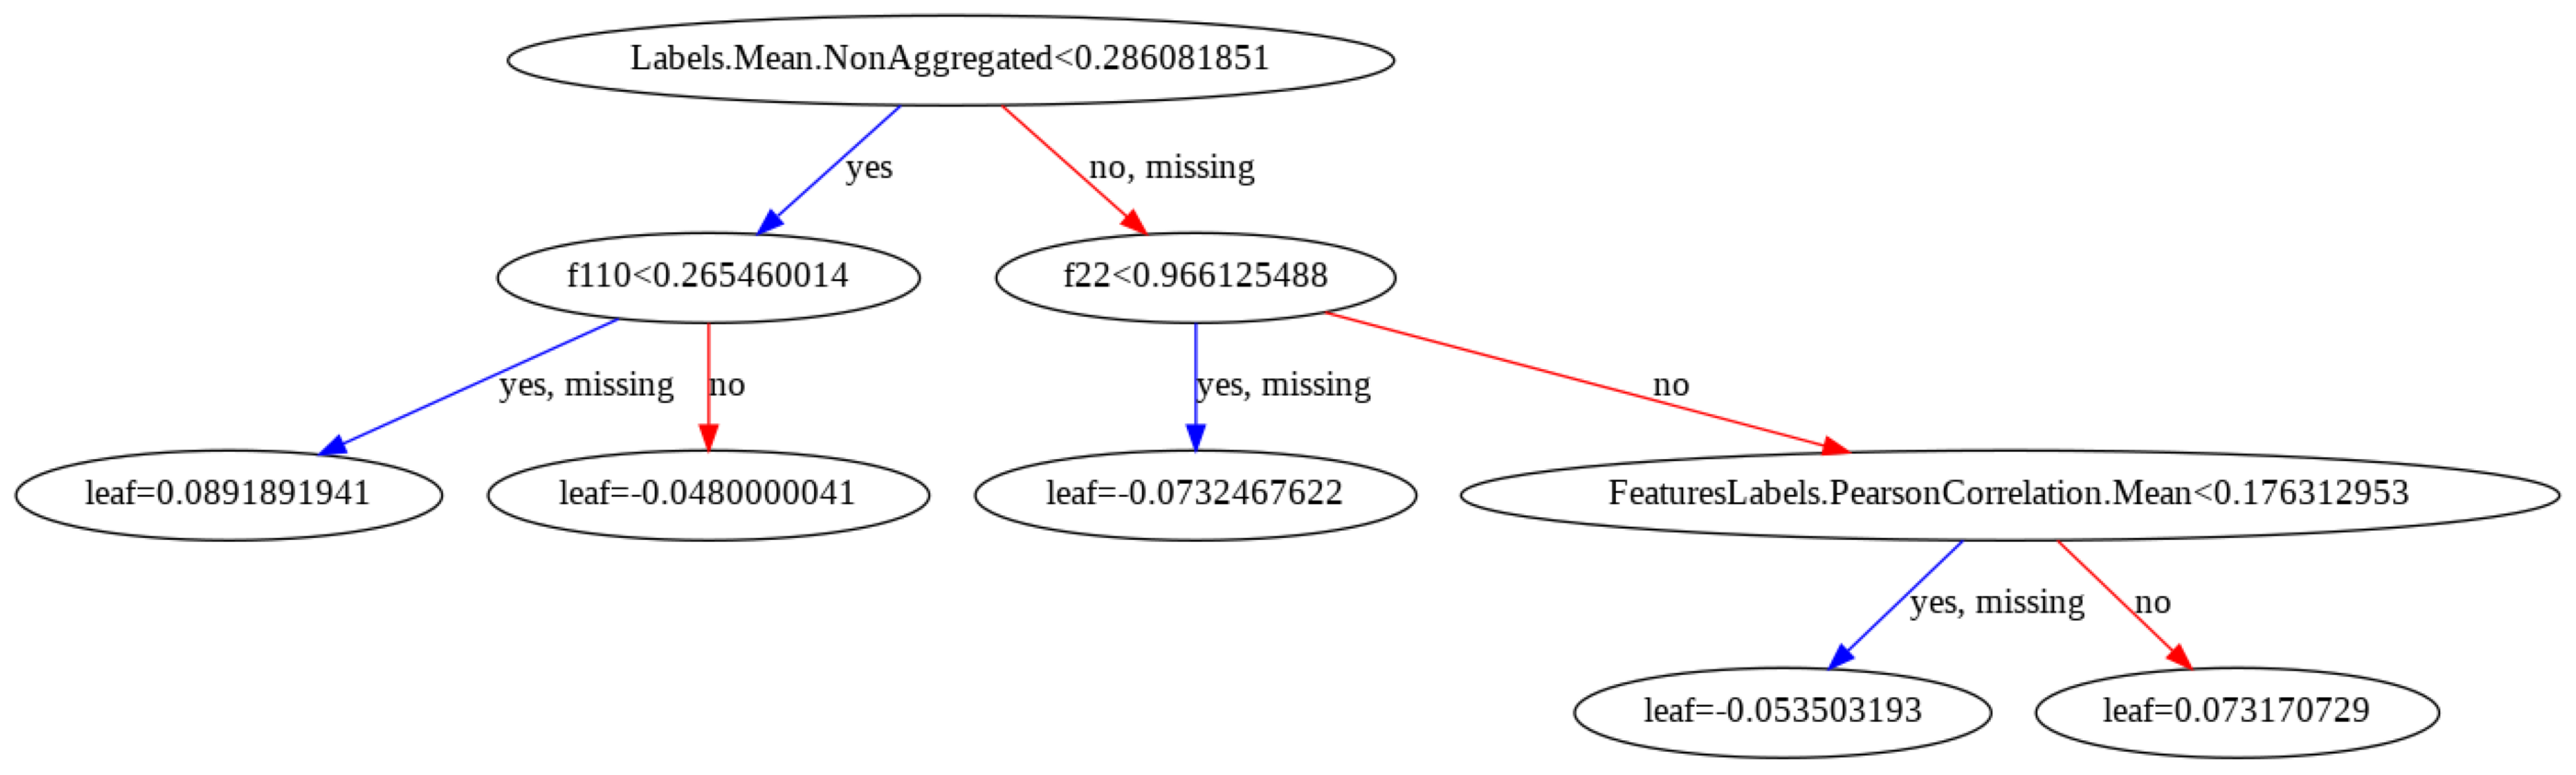

In [28]:
# get feature importance by SHAP

print('SHAP:')
# model.get_booster().predict(xgb.DMatrix(X_test), pred_contribs=True)
fig, ax = plt.subplots(figsize=(50, 50))
xgb.plot_tree(booster=model.get_booster(), ax=ax, num_trees=1)
plt.show()